<a href="https://colab.research.google.com/github/egencer9/460/blob/main/Deep_Learning_Project_Final_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Results will be saved to: ./results

⚠️ RUNNING IN DEMO MODE (Hızlı, Düşük Doğruluk) ⚠️

>>> PART 1: Main Comparative Study (ResNet vs VGG)

EXP (Main): ResNet18 on CIFAR10 (WD=0.0005)

Preparing Data: CIFAR10...


100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


  -> Subsetting: Train size 2500, Test size 500
  [Epoch 1] Loss: 2.425 | Acc: 18.72%
  [Epoch 2] Loss: 2.246 | Acc: 24.20%
  [Result] Acc: 26.75% | ECE: 0.1758
  [Graph] Saved: ./results/ResNet18_CIFAR10_uncalibrated.png


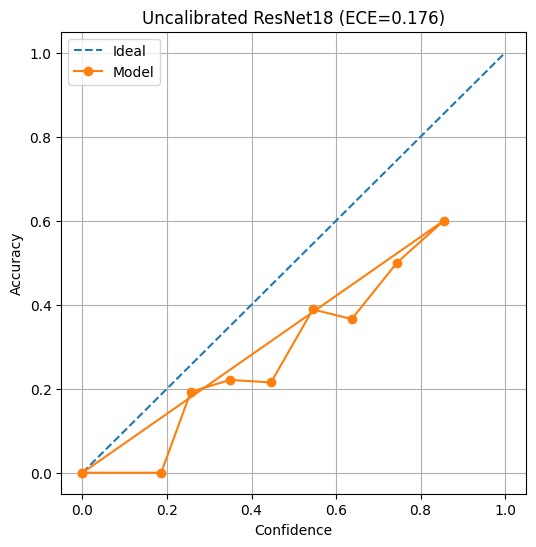

Applying Temperature Scaling...


/usr/local/lib/python3.12/dist-packages/torch/optim/lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  loss = float(closure())


  Optimal temperature found: 1.686
  [Graph] Saved: ./results/ResNet18_CIFAR10_calibrated.png


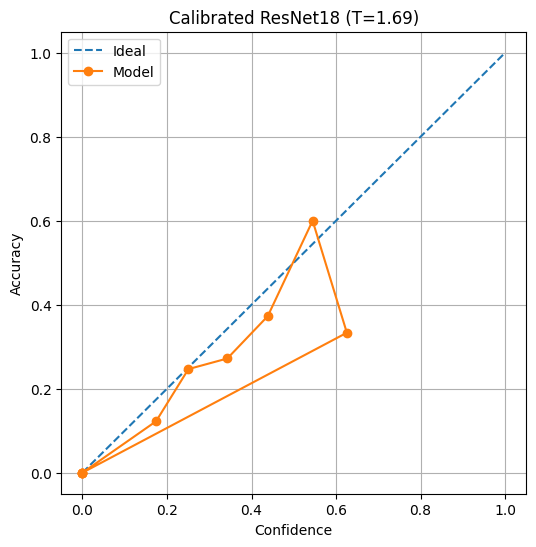


EXP (Main): VGG11 on CIFAR10 (WD=0.0005)

Preparing Data: CIFAR10...
  -> Subsetting: Train size 2500, Test size 500
  [Epoch 1] Loss: 2.722 | Acc: 13.84%
  [Epoch 2] Loss: 2.274 | Acc: 18.36%
  [Result] Acc: 23.50% | ECE: 0.0829
  [Graph] Saved: ./results/VGG11_CIFAR10_uncalibrated.png


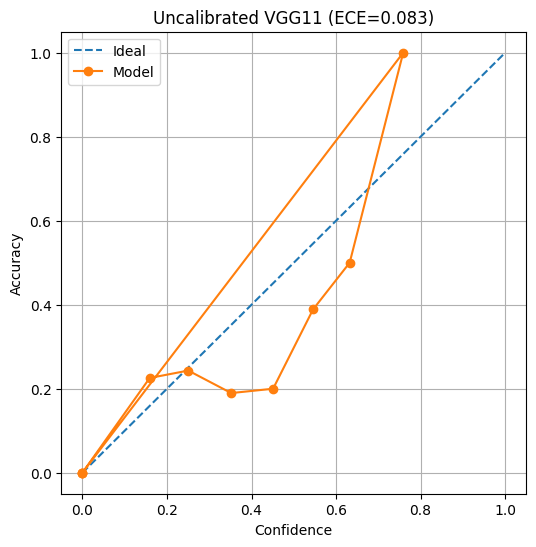

Applying Temperature Scaling...
  Optimal temperature found: 1.253
  [Graph] Saved: ./results/VGG11_CIFAR10_calibrated.png


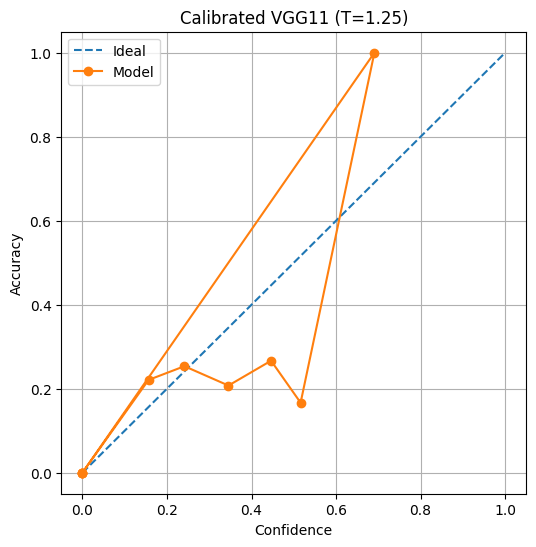


>>> PART 2: Ablation Study - Effect of Weight Decay on Calibration

EXP (Ablation): ResNet18 on CIFAR10 (WD=0)

Preparing Data: CIFAR10...
  -> Subsetting: Train size 2500, Test size 500
  [Epoch 1] Loss: 2.322 | Acc: 21.24%
  [Result] Acc: 16.50% | ECE: 0.6527

EXP (Ablation): ResNet18 on CIFAR10 (WD=0.0001)

Preparing Data: CIFAR10...
  -> Subsetting: Train size 2500, Test size 500
  [Epoch 1] Loss: 2.389 | Acc: 19.40%
  [Result] Acc: 17.50% | ECE: 0.3644

EXP (Ablation): ResNet18 on CIFAR10 (WD=0.001)

Preparing Data: CIFAR10...
  -> Subsetting: Train size 2500, Test size 500
  [Epoch 1] Loss: 2.413 | Acc: 20.08%
  [Result] Acc: 21.25% | ECE: 0.3330

EXP (Ablation): ResNet18 on CIFAR10 (WD=0.005)

Preparing Data: CIFAR10...
  -> Subsetting: Train size 2500, Test size 500
  [Epoch 1] Loss: 2.411 | Acc: 16.40%
  [Result] Acc: 22.75% | ECE: 0.3873
  [Ablation] Saved: ./results/ablation_weight_decay_ece.png


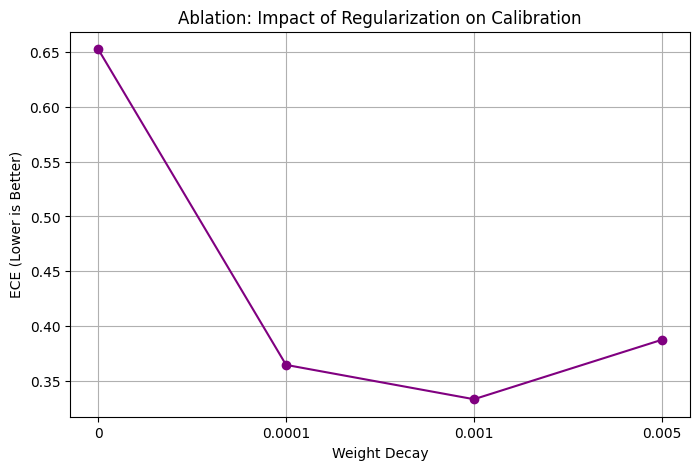



================ SUMMARY RESULTS ================
Exp Type   | Model/Data           | Orig ECE   | Calib ECE 
------------------------------------------------------------
Main       | ResNet18/CIFAR10     | 0.1758     | 0.0478
Main       | VGG11/CIFAR10        | 0.0829     | 0.0820

--- Ablation Results (Weight Decay vs ECE) ---
WD: 0        | ECE: 0.6527
WD: 0.0001   | ECE: 0.3644
WD: 0.001    | ECE: 0.3330
WD: 0.005    | ECE: 0.3873

[INFO] DONE! Results saved to: ./results


In [1]:

# # Deep Learning Project: Model Evaluation & Calibration (Topic 9)
#
# **Student ID Ends with:** 9
# **Topic:** Model Evaluation & Calibration
# **Objective:** Train models, measure their calibration error (ECE), apply Temperature Scaling, and perform Ablation Studies.

# %%
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import sys

# ==========================================
# 0. SETUP & LOGGING
# ==========================================

# Create results directory
RESULTS_DIR = './results'
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Logger Helper: Hem ekrana hem dosyaya yazar
class DualLogger:
    def __init__(self, filepath):
        self.terminal = sys.stdout
        self.log = open(filepath, "w", encoding='utf-8')

    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)
        self.log.flush()

    def flush(self):
        self.terminal.flush()
        self.log.flush()

# Logları dosyaya yönlendir
sys.stdout = DualLogger(os.path.join(RESULTS_DIR, "training_log.txt"))

print(f"Using device: {device}")
print(f"Results will be saved to: {RESULTS_DIR}")

# ==========================================
# HYPERPARAMETERS & DEMO SWITCH
# ==========================================

# --- DEMO SETTINGS (Hızlı test için) ---
# Rapor için çalıştırırken burayı False yap!
DEMO_MODE = True

if DEMO_MODE:
    print("\n⚠️ RUNNING IN DEMO MODE (Hızlı, Düşük Doğruluk) ⚠️")
    BATCH_SIZE = 64
    NUM_EPOCHS = 2          # Gerçek: 30-50
    LEARNING_RATE = 0.01
    DATA_SUBSET_RATIO = 0.05 # Verinin sadece %5'i
    ABLATION_EPOCHS = 1      # Ablasyon için çok hızlı tur
else:
    print("\n🚀 RUNNING IN FULL MODE (Yavaş, Yüksek Doğruluk) 🚀")
    BATCH_SIZE = 128
    NUM_EPOCHS = 20
    LEARNING_RATE = 0.001
    DATA_SUBSET_RATIO = 1.0
    ABLATION_EPOCHS = 10

# ==========================================
# 1. DATA PREPARATION
# ==========================================

def get_dataloaders(dataset_name='CIFAR10'):
    print(f"\nPreparing Data: {dataset_name}...")

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    if dataset_name == 'CIFAR10':
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    elif dataset_name == 'SVHN':
        trainset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform_train)
        testset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform_test)

    # DEMO Modu için veriyi küçült
    if DATA_SUBSET_RATIO < 1.0:
        train_indices = np.random.choice(len(trainset), int(len(trainset) * DATA_SUBSET_RATIO), replace=False)
        test_indices = np.random.choice(len(testset), int(len(testset) * DATA_SUBSET_RATIO), replace=False)
        trainset = Subset(trainset, train_indices)
        testset = Subset(testset, test_indices)
        print(f"  -> Subsetting: Train size {len(trainset)}, Test size {len(testset)}")

    # Validation Set Ayırma (Temperature Scaling için zorunlu)
    val_size = int(0.2 * len(testset)) # Test setinin %20'si validasyon olsun
    test_size = len(testset) - val_size
    val_set, test_set = torch.utils.data.random_split(testset, [val_size, test_size])

    trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    valloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    return trainloader, valloader, testloader

# ==========================================
# 2. METRICS & PLOTTING
# ==========================================

def calc_ece(logits, labels, n_bins=15):
    """Expected Calibration Error (ECE) hesaplar."""
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    softmaxes = F.softmax(logits, dim=1)
    confidences, predictions = torch.max(softmaxes, 1)
    accuracies = predictions.eq(labels)

    ece = torch.zeros(1, device=logits.device)

    for bin_lower, bin_upper in zip(bin_boundaries[:-1], bin_boundaries[1:]):
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()

        if prop_in_bin.item() > 0:
            accuracy_in_bin = accuracies[in_bin].float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

    return ece.item()

def plot_reliability_diagram(logits, labels, title="Reliability Diagram", filename=None):
    """Güvenilirlik diyagramı çizer ve kaydeder."""
    softmaxes = F.softmax(logits, dim=1)
    confidences, predictions = torch.max(softmaxes, 1)
    accuracies = predictions.eq(labels)

    n_bins = 10
    bin_boundaries = np.linspace(0, 1, n_bins + 1)

    bin_accs = []
    bin_confs = []

    for bin_lower, bin_upper in zip(bin_boundaries[:-1], bin_boundaries[1:]):
        in_bin = confidences.gt(bin_lower) * confidences.le(bin_upper)
        if in_bin.float().sum() > 0:
            bin_accs.append(accuracies[in_bin].float().mean().cpu().item())
            bin_confs.append(confidences[in_bin].mean().cpu().item())
        else:
            bin_accs.append(0)
            bin_confs.append(0)

    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Ideal')
    plt.plot(bin_confs, bin_accs, marker='o', label='Model')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.grid(True)

    if filename:
        save_path = os.path.join(RESULTS_DIR, filename)
        plt.savefig(save_path)
        print(f"  [Graph] Saved: {save_path}")

    plt.show()
    plt.close()

def plot_ablation_study(x_values, y_values, x_label, y_label, title, filename):
    """Ablasyon grafiği çizer."""
    plt.figure(figsize=(8, 5))
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='purple')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)

    save_path = os.path.join(RESULTS_DIR, filename)
    plt.savefig(save_path)
    print(f"  [Ablation] Saved: {save_path}")
    plt.show()
    plt.close()

# ==========================================
# 3. MODELS
# ==========================================

def get_model(model_name='ResNet18', num_classes=10):
    if model_name == 'ResNet18':
        model = torchvision.models.resnet18(weights=None)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'VGG11':
        model = torchvision.models.vgg11_bn(weights=None)
        model.classifier[6] = nn.Linear(4096, num_classes)
    return model.to(device)

# ==========================================
# 4. TRAINING & EVALUATION
# ==========================================

def train(model, loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    acc = 100. * correct / total
    # Sadece ilk ve son epochta yazdır ki log kirlenmesin
    print(f"  [Epoch {epoch+1}] Loss: {running_loss/len(loader):.3f} | Acc: {acc:.2f}%")
    return acc, running_loss/len(loader)

def evaluate(model, loader):
    model.eval()
    logits_list = []
    labels_list = []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            logits_list.append(outputs)
            labels_list.append(targets)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    logits = torch.cat(logits_list).to(device)
    labels = torch.cat(labels_list).to(device)

    acc = 100. * correct / total
    nll = F.cross_entropy(logits, labels).item()
    ece = calc_ece(logits, labels)

    return acc, nll, ece, logits, labels

# ==========================================
# 5. CALIBRATION (Temperature Scaling)
# ==========================================

class ModelWithTemperature(nn.Module):
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / temperature

    def set_temperature(self, valid_loader):
        self.cuda()
        nll_criterion = nn.CrossEntropyLoss().cuda()

        logits_list = []
        labels_list = []
        with torch.no_grad():
            for input, label in valid_loader:
                input = input.cuda()
                logits_list.append(self.model(input))
                labels_list.append(label)
        logits = torch.cat(logits_list).cuda()
        labels = torch.cat(labels_list).cuda()

        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

        def eval():
            optimizer.zero_grad()
            loss = nll_criterion(self.temperature_scale(logits), labels)
            loss.backward()
            return loss

        optimizer.step(eval)
        print(f"  Optimal temperature found: {self.temperature.item():.3f}")

# ==========================================
# 6. EXPERIMENT RUNNER
# ==========================================

def run_experiment(dataset_name, model_name, weight_decay=5e-4, epochs=NUM_EPOCHS, description="Main"):
    print(f"\n{'='*40}\nEXP ({description}): {model_name} on {dataset_name} (WD={weight_decay})\n{'='*40}")

    train_loader, val_loader, test_loader = get_dataloaders(dataset_name)
    model = get_model(model_name)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=weight_decay)

    # Train
    for epoch in range(epochs):
        train(model, train_loader, optimizer, criterion, epoch)

    # Evaluate Baseline
    test_acc, test_nll, test_ece, test_logits, test_labels = evaluate(model, test_loader)
    print(f"  [Result] Acc: {test_acc:.2f}% | ECE: {test_ece:.4f}")

    # IF MAIN EXPERIMENT: Do Full Visualization & Calibration
    if description == "Main":
        base_filename = f"{model_name}_{dataset_name}"
        plot_reliability_diagram(
            test_logits, test_labels,
            title=f"Uncalibrated {model_name} (ECE={test_ece:.3f})",
            filename=f"{base_filename}_uncalibrated.png"
        )

        print("Applying Temperature Scaling...")
        scaled_model = ModelWithTemperature(model)
        scaled_model.set_temperature(val_loader)
        cal_acc, cal_nll, cal_ece, cal_logits, cal_labels = evaluate(scaled_model, test_loader)

        plot_reliability_diagram(
            cal_logits, cal_labels,
            title=f"Calibrated {model_name} (T={scaled_model.temperature.item():.2f})",
            filename=f"{base_filename}_calibrated.png"
        )

        return {
            "Type": "Main", "Model": model_name, "Dataset": dataset_name,
            "Orig_Acc": round(test_acc, 2), "Orig_ECE": round(test_ece, 4),
            "Calib_ECE": round(cal_ece, 4), "Temperature": round(scaled_model.temperature.item(), 3)
        }
    else:
        # IF ABLATION: Just return numbers
        return {"Weight_Decay": weight_decay, "Acc": test_acc, "ECE": test_ece}

# ==========================================
# 7. MAIN EXECUTION
# ==========================================

results_list = []

# --- PART 1: MAIN COMPARATIVE STUDY (Model & Dataset) ---
print("\n>>> PART 1: Main Comparative Study (ResNet vs VGG)")
results_list.append(run_experiment('CIFAR10', 'ResNet18', description="Main"))
results_list.append(run_experiment('CIFAR10', 'VGG11', description="Main"))

# --- PART 2: ABLATION STUDY (Weight Decay Impact) ---
print("\n>>> PART 2: Ablation Study - Effect of Weight Decay on Calibration")
wd_values = [0, 1e-4, 1e-3, 5e-3]
ablation_ece_scores = []
ablation_acc_scores = []

for wd in wd_values:
    res = run_experiment('CIFAR10', 'ResNet18', weight_decay=wd, epochs=ABLATION_EPOCHS, description="Ablation")
    ablation_ece_scores.append(res['ECE'])
    ablation_acc_scores.append(res['Acc'])

# Plot Ablation
plot_ablation_study(
    [str(w) for w in wd_values], ablation_ece_scores,
    "Weight Decay", "ECE (Lower is Better)",
    "Ablation: Impact of Regularization on Calibration",
    "ablation_weight_decay_ece.png"
)

# --- SAVE & SUMMARY ---
print("\n\n================ SUMMARY RESULTS ================")
print(f"{'Exp Type':<10} | {'Model/Data':<20} | {'Orig ECE':<10} | {'Calib ECE':<10}")
print("-" * 60)
for r in results_list:
    name = f"{r['Model']}/{r['Dataset']}"
    print(f"{r['Type']:<10} | {name:<20} | {r['Orig_ECE']:.4f}     | {r['Calib_ECE']:.4f}")

print("\n--- Ablation Results (Weight Decay vs ECE) ---")
for wd, ece in zip(wd_values, ablation_ece_scores):
    print(f"WD: {wd:<8} | ECE: {ece:.4f}")

# CSV Save
csv_path = os.path.join(RESULTS_DIR, 'experiment_results.csv')
if results_list:
    keys = results_list[0].keys()
    with open(csv_path, 'w', newline='') as output_file:
        dict_writer = csv.DictWriter(output_file, fieldnames=keys)
        dict_writer.writeheader()
        dict_writer.writerows(results_list)

print(f"\n[INFO] DONE! Results saved to: {RESULTS_DIR}")